In [59]:
# Import Libraries
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [60]:
# Import Data
path = '/Users/las/Documents/GitHub/REU/hill_climb_w_solution_counts.xlsx'
df = pd.read_excel(path)
data = df[[col for col in df.columns if col[0].isupper()]].rename(str.lower, axis='columns')
df.head()

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,B4,B5,B6,C1,C2,C3,C4,C5,C6,Counts
0,0.080945,0.360232,0.057056,0.749259,0.955720,0.807542,0.632065,0.987198,0.858777,0.747515,...,1.009519,0.753096,0.486770,-0.004601,0.190029,0.265888,0.167961,0.726625,0.297465,26
1,0.020657,0.528250,0.785039,0.140394,0.629471,0.232232,0.442754,0.177439,0.541098,0.378114,...,0.461198,0.016416,0.170428,0.486811,0.728032,0.885663,0.050032,0.648216,0.157806,0
2,0.524718,0.271188,0.617312,0.352435,0.446476,0.870586,0.790443,0.930621,0.314740,0.650593,...,0.638183,0.010259,-0.030974,0.778479,1.059313,0.434567,0.503703,0.603667,0.192912,10
3,0.391623,0.766953,0.151090,0.986174,0.769373,0.199420,0.685867,0.058377,0.051811,0.073706,...,0.064034,0.401679,0.929817,0.090694,0.480075,0.301884,0.614086,0.812183,0.725908,20
4,0.914580,0.289532,0.338711,0.269049,0.688129,0.896449,0.850288,0.451521,0.327267,0.763946,...,0.408069,0.124350,-0.231770,0.388754,0.696648,0.785599,0.885972,0.387142,0.583846,8


In [63]:
# Create Training and Validation Data
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data.drop('counts', axis=1).values.tolist(), dtype=np.float64),
    np.array(data['counts'].values.tolist(), dtype=int)/2, 
    test_size=0.2, random_state=42)

In [64]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dense(units=93, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              19000     
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_11 (Dense)             (None, 93)                93093     
Total params: 1,113,093
Trainable params: 1,113,093
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Set up training
sce = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])

In [66]:
# Train model
history = model.fit(
    X_test,
    y_test,
    verbose=0,
    epochs=15,
    batch_size=64,
    validation_data=(
        X_test,
        y_test
    )
)

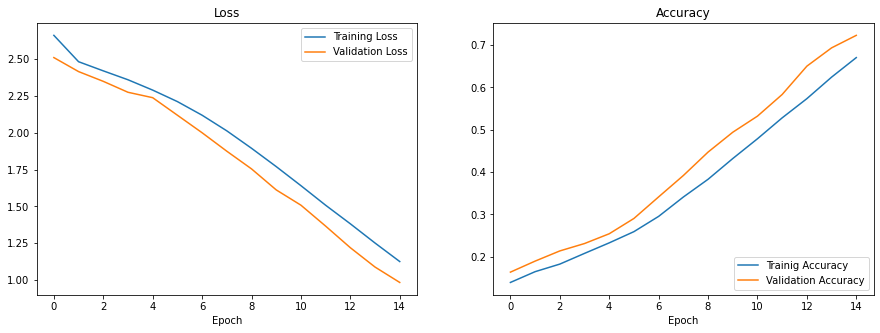

In [67]:
# Graphs
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['loss'], label="Training Loss") 
axs[0].plot(history.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(history.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')